# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torchvision import datasets, transforms
import torchvision

import sys, os
import matplotlib.pyplot as plt

import numpy as np
import random


import custom_resnet

from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

from modular.create_data_loader import create_train_data_loader, create_test_data_loader
from modular.dataloader import Cifar10SearchDataset
from modular.transforms import CustomResnetTransforms
from modular.train import model_training, model_testing
from modular.plots import plot_losses,plot_images 

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
device = torch.device("cuda" if cuda else "cpu")
print(device)

CUDA Available? True
cuda


# Transformation of Data

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)
print (train_transforms)
print (test_transforms)

Compose([
  Normalize(always_apply=True, p=1.0, mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616], max_pixel_value=255.0),
  PadIfNeeded(always_apply=True, p=1.0, min_height=40, min_width=40, pad_height_divisor=None, pad_width_divisor=None, border_mode=4, value=None, mask_value=None),
  RandomCrop(always_apply=True, p=1.0, height=32, width=32),
  HorizontalFlip(always_apply=False, p=0.5),
  CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=[0.4914, 0.4822, 0.4465], mask_fill_value=None),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Compose([
  Normalize(always_apply=True, p=1.0, mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


# Dataset and Creating Train/Test Split

In [5]:
train = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

print (len(train_loader),len(test_loader))

98 20


# Model Params for Custom Resnet
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
m = custom_resnet.resnet_model().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## Calculating the max and min LR using one cycle LR policy

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.66E-03


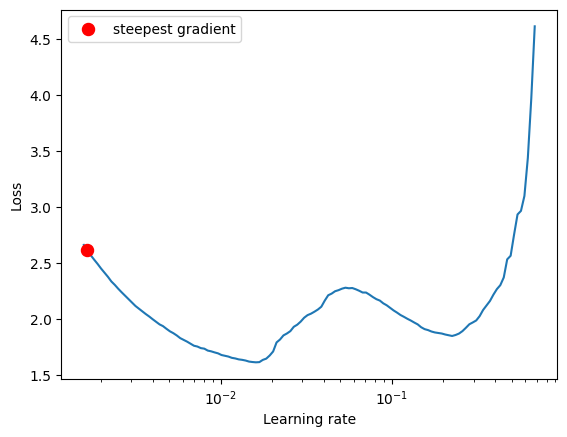

SystemExit: 

In [8]:
m = custom_resnet.resnet_model().to(device)
optimizer = optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(m, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state
sys.exit()

# Let's Train and test our model
### using one cycle lr policy

In [9]:
EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=1.66E-03,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start= 5.0/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear',
    )


In [10]:
for epoch in range(EPOCHS):
    print("EPOCH: "+ str(epoch)),
    train_acc,train_losses = model_training(m, device, train_loader, optimizer, epoch, scheduler, criterion)
    test_acc,test_losses,miss_classified_data = model_testing(m, device, test_loader, criterion)

EPOCH: 0


Loss=1.1588484048843384 LR =0.0003459521472392638 Batch_id=97 Accuracy=44.66: 100% 98/98 [00:08<00:00, 10.96it/s] 



Test set: Average loss: 0.0023, Accuracy: 5943/10000 (59.43%)

EPOCH: 1


Loss=0.8895152807235718 LR =0.0006753042944785276 Batch_id=97 Accuracy=64.59: 100% 98/98 [00:08<00:00, 11.03it/s] 



Test set: Average loss: 0.0024, Accuracy: 6048/10000 (60.48%)

EPOCH: 2


Loss=0.7314085960388184 LR =0.0010046564417177915 Batch_id=97 Accuracy=73.60: 100% 98/98 [00:08<00:00, 11.05it/s]



Test set: Average loss: 0.0016, Accuracy: 7379/10000 (73.79%)

EPOCH: 3


Loss=0.6716450452804565 LR =0.0013340085889570552 Batch_id=97 Accuracy=78.19: 100% 98/98 [00:08<00:00, 10.89it/s]



Test set: Average loss: 0.0012, Accuracy: 7915/10000 (79.15%)

EPOCH: 4


Loss=0.49618253111839294 LR =0.001659108574650913 Batch_id=97 Accuracy=80.87: 100% 98/98 [00:08<00:00, 11.00it/s] 



Test set: Average loss: 0.0013, Accuracy: 7842/10000 (78.42%)

EPOCH: 5


Loss=0.5347700715065002 LR =0.0015717488904403868 Batch_id=97 Accuracy=82.67: 100% 98/98 [00:08<00:00, 11.24it/s] 



Test set: Average loss: 0.0010, Accuracy: 8226/10000 (82.26%)

EPOCH: 6


Loss=0.391071081161499 LR =0.0014843892062298605 Batch_id=97 Accuracy=85.82: 100% 98/98 [00:08<00:00, 10.95it/s]  



Test set: Average loss: 0.0011, Accuracy: 8109/10000 (81.09%)

EPOCH: 7


Loss=0.35507506132125854 LR =0.0013970295220193342 Batch_id=97 Accuracy=86.88: 100% 98/98 [00:09<00:00, 10.74it/s]



Test set: Average loss: 0.0009, Accuracy: 8460/10000 (84.60%)

EPOCH: 8


Loss=0.31682828068733215 LR =0.0013096698378088079 Batch_id=97 Accuracy=88.16: 100% 98/98 [00:08<00:00, 11.33it/s]



Test set: Average loss: 0.0009, Accuracy: 8534/10000 (85.34%)

EPOCH: 9


Loss=0.2833311855792999 LR =0.0012223101535982813 Batch_id=97 Accuracy=89.19: 100% 98/98 [00:08<00:00, 11.06it/s] 



Test set: Average loss: 0.0008, Accuracy: 8650/10000 (86.50%)

EPOCH: 10


Loss=0.3125080466270447 LR =0.0011349504693877552 Batch_id=97 Accuracy=89.92: 100% 98/98 [00:08<00:00, 11.13it/s] 



Test set: Average loss: 0.0008, Accuracy: 8566/10000 (85.66%)

EPOCH: 11


Loss=0.29194408655166626 LR =0.0010475907851772287 Batch_id=97 Accuracy=90.28: 100% 98/98 [00:08<00:00, 10.94it/s]



Test set: Average loss: 0.0008, Accuracy: 8644/10000 (86.44%)

EPOCH: 12


Loss=0.26798462867736816 LR =0.0009602311009667024 Batch_id=97 Accuracy=90.97: 100% 98/98 [00:08<00:00, 11.18it/s]



Test set: Average loss: 0.0009, Accuracy: 8540/10000 (85.40%)

EPOCH: 13


Loss=0.24786284565925598 LR =0.0008728714167561761 Batch_id=97 Accuracy=91.89: 100% 98/98 [00:09<00:00, 10.77it/s]



Test set: Average loss: 0.0009, Accuracy: 8564/10000 (85.64%)

EPOCH: 14


Loss=0.2269628643989563 LR =0.0007855117325456498 Batch_id=97 Accuracy=92.43: 100% 98/98 [00:08<00:00, 11.26it/s] 



Test set: Average loss: 0.0009, Accuracy: 8540/10000 (85.40%)

EPOCH: 15


Loss=0.16990764439105988 LR =0.0006981520483351236 Batch_id=97 Accuracy=93.05: 100% 98/98 [00:08<00:00, 11.16it/s]



Test set: Average loss: 0.0007, Accuracy: 8784/10000 (87.84%)

EPOCH: 16


Loss=0.20494084060192108 LR =0.0006107923641245972 Batch_id=97 Accuracy=93.72: 100% 98/98 [00:08<00:00, 11.22it/s]



Test set: Average loss: 0.0007, Accuracy: 8859/10000 (88.59%)

EPOCH: 17


Loss=0.17789027094841003 LR =0.0005234326799140709 Batch_id=97 Accuracy=94.13: 100% 98/98 [00:08<00:00, 11.23it/s]



Test set: Average loss: 0.0007, Accuracy: 8877/10000 (88.77%)

EPOCH: 18


Loss=0.18473023176193237 LR =0.0004360729957035446 Batch_id=97 Accuracy=94.95: 100% 98/98 [00:08<00:00, 11.21it/s] 



Test set: Average loss: 0.0006, Accuracy: 8984/10000 (89.84%)

EPOCH: 19


Loss=0.15550050139427185 LR =0.0003487133114930183 Batch_id=97 Accuracy=95.67: 100% 98/98 [00:08<00:00, 11.04it/s] 



Test set: Average loss: 0.0006, Accuracy: 9075/10000 (90.75%)

EPOCH: 20


Loss=0.1182783991098404 LR =0.000261353627282492 Batch_id=97 Accuracy=96.58: 100% 98/98 [00:08<00:00, 10.90it/s]   



Test set: Average loss: 0.0005, Accuracy: 9207/10000 (92.07%)

EPOCH: 21


Loss=0.05995209887623787 LR =0.00017399394307196568 Batch_id=97 Accuracy=97.29: 100% 98/98 [00:08<00:00, 11.15it/s] 



Test set: Average loss: 0.0005, Accuracy: 9256/10000 (92.56%)

EPOCH: 22


Loss=0.07348146289587021 LR =8.663425886143938e-05 Batch_id=97 Accuracy=98.00: 100% 98/98 [00:08<00:00, 11.09it/s]  



Test set: Average loss: 0.0004, Accuracy: 9316/10000 (93.16%)

EPOCH: 23


Loss=0.05063890293240547 LR =-7.254253490869295e-07 Batch_id=97 Accuracy=98.56: 100% 98/98 [00:08<00:00, 11.09it/s] 



Test set: Average loss: 0.0004, Accuracy: 9324/10000 (93.24%)



## Displaying Train Test Accuracy and Loss Plots

mkdir: cannot create directory ‘images’: File exists


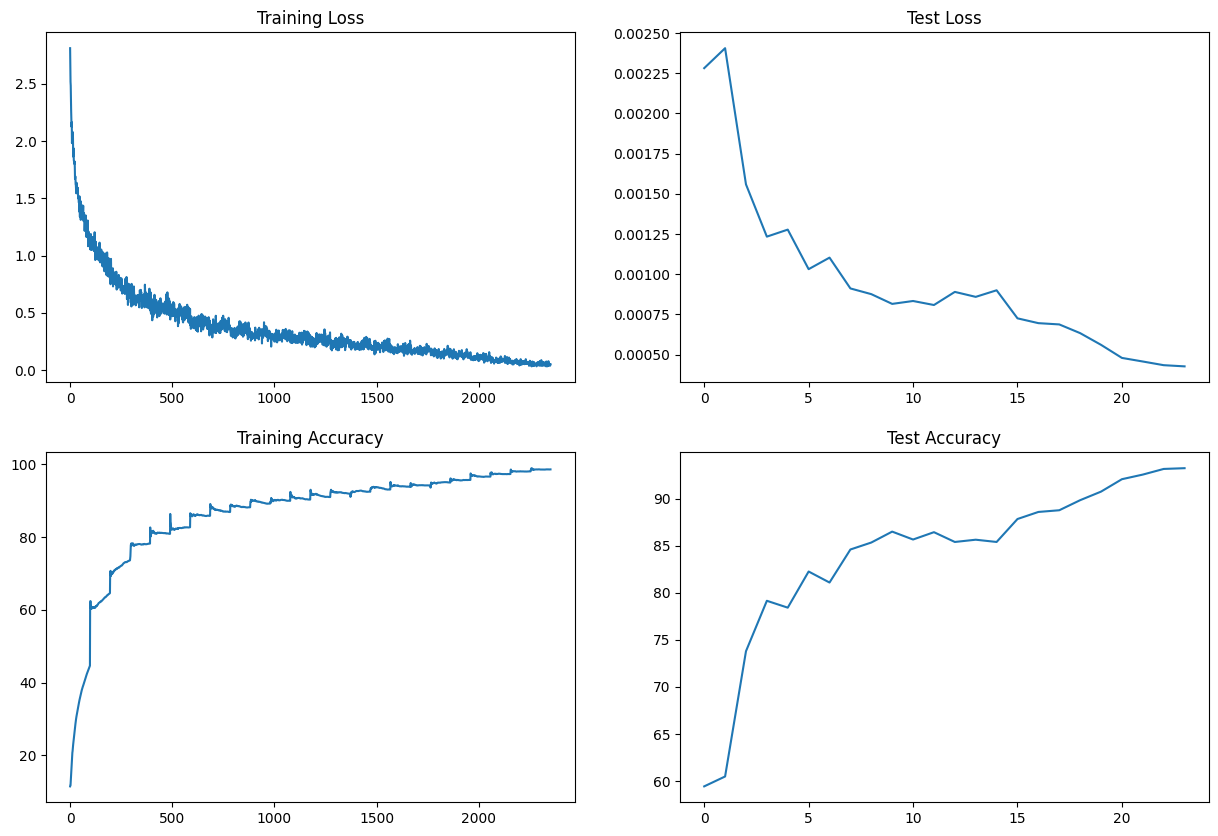

In [11]:
os.system('mkdir images')
fig = plot_losses(train_losses, train_acc, test_losses, test_acc)
fig.savefig('images/Accuracy & Loss.jpg')

## Displaying Sample Miss Classified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

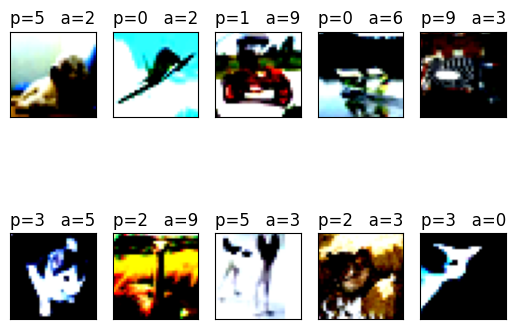

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

random_images = range(0,len(miss_classified_data[0]))
random_selects = random.sample(random_images, 10)

fig_miss_class = plt.figure()
count=0
for i in random_selects:
    plt.subplot(2,5,count+1)
    plt.imshow(miss_classified_data[2][i].cpu().permute(1,2,0))   
    plt.title("p="+str(miss_classified_data[1][i])+"   "+"a="+str(miss_classified_data[0][i]))
    plt.xticks([])
    plt.yticks([])
    count+=1

fig_miss_class.savefig("images/mis_classified_image.jpg")

## Displaying Sample Train Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

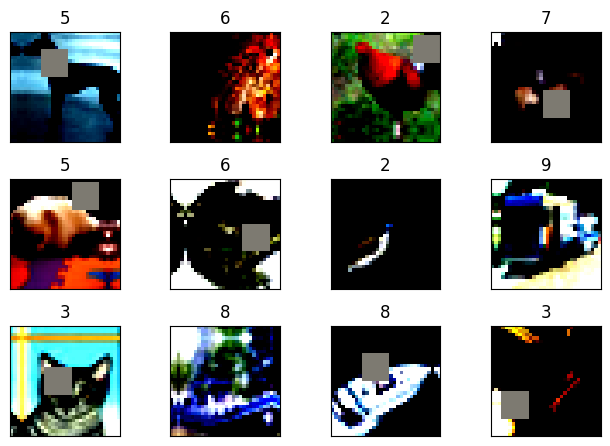

In [13]:
batch_data_train, batch_label_train = next(iter(train_loader))
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("images/train_dataset.jpg")

## Displaying Sample Test Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

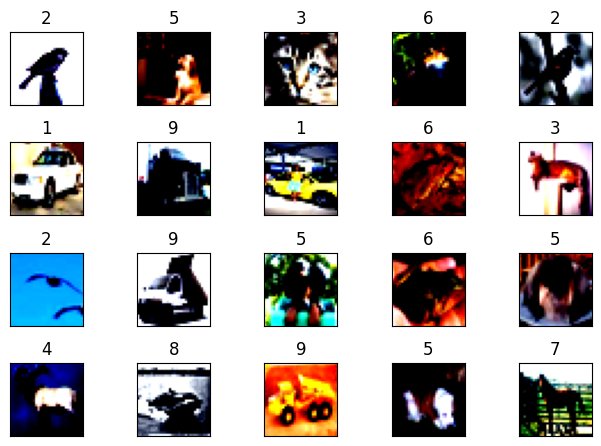

In [14]:
batch_data_test, batch_label_test = next(iter(test_loader))
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_test.savefig("images/test_dataset.jpg")

**********************************************************